**Students Details:**


1.  Naveen Baburaj - 201665419
2.  Ogochukwu Okafor - 201666459



**STEP ONE (1)**
Importing the libraries

In [ ]:
# Importing the libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.testing import test
import traceback
from sklearn.model_selection import KFold, RandomizedSearchCV
import time
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [ ]:
# Setting the system using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setting up the transform pipeline to convert the images to PyTorch tensors
t = transforms.Compose([ # enabling transformation pipelines by combining several transformations into a single pipeline.
    transforms.ToTensor(), # transforming input images to tensors
    transforms.Normalize((0.1733,), (0.3311,))]) # normalizing the tensor values with a mean of  0.1733 and a standard deviation of  0.3311.

**STEP 2 to 3**


2.  Step Loading the EMNIST "Balanced" dataset
3.  Splitting the datasets into train data and test data




In [ ]:
# Loading the EMNIST "Balanced" dataset
directory = './emnist'

# Setting the random seed for consistency
torch.manual_seed(42)
# STEP THREE (3)
# Splitting the datasets into train data and test data

train_data = torchvision.datasets.EMNIST(root=directory, split='balanced', train=True, transform=t, download=True) # loading the train data
test_data = torchvision.datasets.EMNIST(root=directory, split='balanced', train=False, transform=t, download=True) # loading the test data

# Loading the splitted data loaders for the train data and test data
trains = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True) # splitted train datasets
tests = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False) # splitted test datasets

100%|██████████| 561753746/561753746 [00:06<00:00, 83423244.24it/s]


Extracting ./emnist/EMNIST/raw/gzip.zip to ./emnist/EMNIST/raw


**STEP FOUR (4)**


*  Printing out the number of training/testing samples in the dataset.
*  Plotting some figures to visualize some samples in the dataset 





EMNIST Balanced Dataset Information:
Train: 112,800
Test: 18,800
Total: 131,600
Classes: 47 (balanced)


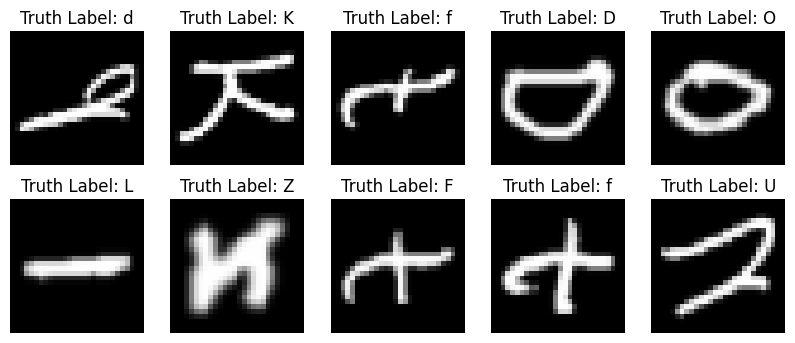

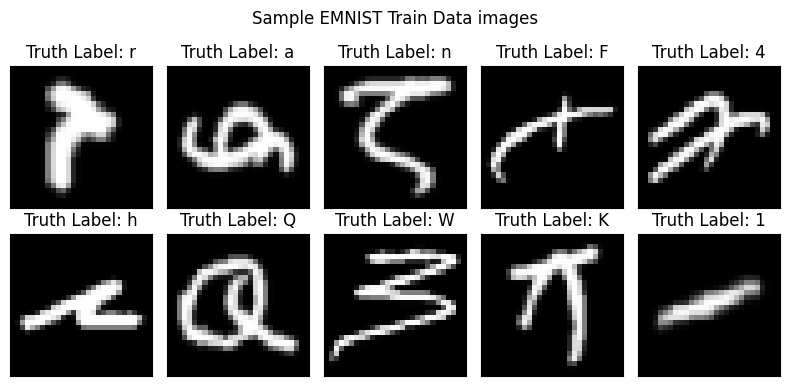

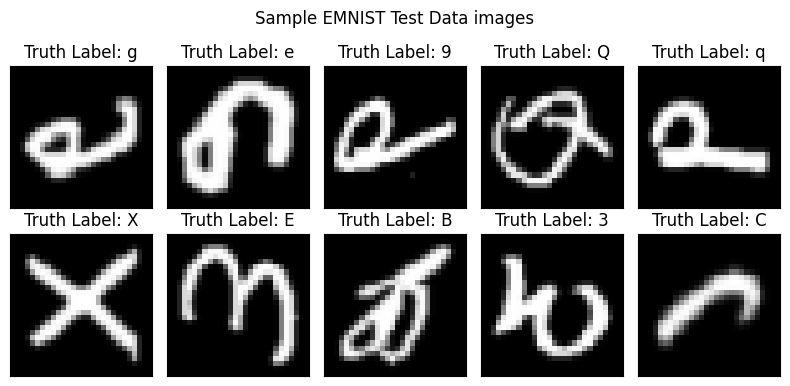

In [ ]:
# Printing the dataset information of the '/emnist-balanced-mapping.txt' text file.
print("EMNIST Balanced Dataset Information:\nTrain: " + "{:,}".format(len(train_data)) + 
      "\nTest: " + "{:,}".format(len(test_data)) + 
      "\nTotal: " + "{:,}".format(len(train_data) + len(test_data)) + 
      "\nClasses: " + str(len(train_data.classes)) + " (balanced)")

# Visualising the Mapping File
mappings = open('/emnist-balanced-mapping.txt')# open('/emnist-balanced-mapping.txt')  # opening the file containing mapping information
map_lines = mappings.readlines()  # reads all the lines in the mapping file
map_dict = {}  # creates an empty dictionary to hold the mapping information

for line in map_lines:  # iterating over each line in the mapping file
    label, alpha = line.split()  # splits each line into label and corresponding alpha value
    map_dict[int(label)] = chr(int(alpha))  # stores the mapping information in the dictionary

for m, n in trains:  # iterating over the images and labels in the train data loader
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))  # creates a grid of subplots for visualization
    for i, ax in enumerate(axes.flat):  # iterating over every subplot
        ax.imshow(m[i].squeeze(), cmap='gray')  # displaying the ith image in grayscale
        ax.set_title("Truth Label: {}".format(map_dict[n[i].item()]))  # setting the title of the subplot with the corresponding label information
        ax.axis('off')  # removing the axes from the subplot
    plt.show()  # displaying the plot
    break  # breaking the loop after displaying the first batch of images and labels

# Visualising the EMNIST Train Datasets
# Creating a figure with 10 subplots, arranged in 2 rows of 5 subplots each for the train data
fig, axs = plt.subplots(2, 5, figsize=(8, 4)) # creating a figure of 8 inches by 4 inches and having 2 rows and 5 columns of subplots.
axs = axs.flatten() # flattening the axs array to enable a single loop iteration over all subplots.
for i in range(10): # looping through the first 10 images in the train dataset
    axs[i].imshow(train_data[i][0].squeeze(), cmap="gray") # showing the image in grayscale using the imshow functio
    title = map_dict[train_data[i][1]].replace("cm", "") # retrieving the label of the image from the map_dict and removing "cm" from the label
    axs[i].set_title(f"Truth Label: {title}") # setting the title of the subplot with the true label of the image
    axs[i].set_xticks([]) # removing the x ticks from the subplot
    axs[i].set_yticks([]) # removing the y ticks from the subplot 
fig.suptitle("Sample EMNIST Train Data images") # giving the entire train figure a title
fig.tight_layout() # improving the spacing between subplots
plt.show() # displaying the image

# Visualising the EMNIST Test Datasets
# Creating a figure with 10 subplots, arranged in 2 rows of 5 subplots each for the test data
fig, axs = plt.subplots(2, 5, figsize=(8, 4)) # creating a figure of 8 inches by 4 inches and having 2 rows and 5 columns of subplots.
axs = axs.flatten() # flattening the axs array to enable a single loop iteration over all subplots.
for i in range(10): # looping through the first 10 images in the train dataset
    axs[i].imshow(test_data[i][0].squeeze(), cmap="gray")  # showing the image in grayscale using the imshow function
    title = map_dict[test_data[i][1]].replace("cm", "") # retrieving the label of the image from the map_dict and removing "cm" from the label
    axs[i].set_title(f"Truth Label: {title}") # setting the title of the subplot with the true label of the image
    axs[i].set_xticks([]) # removing the x ticks from the subplot
    axs[i].set_yticks([]) # removing the y ticks from the subplot 
fig.suptitle("Sample EMNIST Test Data images") # giving the entire test figure a title
fig.tight_layout() # improving the spacing between subplots
plt.show() # displaying the image

**Step 5**
**Multi-Layer Perceptron (MLP) Neural Network**

**Building the Multi-Layer Perceptron (MLP) Neural Network Using 4 Hidden Layers**

In [ ]:
# Define a function to build the MLP model with different hyperparameters and techniques
def build_mlp(input_size, output_size, hidden_size, activation_function, dropout, batch_norm, l1_reg, l2_reg):
  layers = [] # empty list to hold the four hidden layers
  prev_size = input_size
  for size in hidden_size:
    layers.append(nn.Linear(prev_size, size))
    if batch_norm:
      layers.append(nn.BatchNorm1d(size))
    layers.append(activation_function)
    if dropout:
      layers.append(nn.Dropout(dropout))
    prev_size = size
  layers.append(nn.Linear(prev_size, hidden_size[-1]))
  if batch_norm:
      layers.append(nn.BatchNorm1d(hidden_size[-1]))
  layers.append(activation_function)
  if dropout:
      layers.append(nn.Dropout(dropout))
  layers.append(nn.Linear(hidden_size[-1], hidden_size[-1]))
  if batch_norm:
      layers.append(nn.BatchNorm1d(hidden_size[-1]))
  layers.append(activation_function)
  if dropout:
      layers.append(nn.Dropout(dropout))
  layers.append(nn.Linear(hidden_size[-1], hidden_size[-1]))
  if batch_norm:
      layers.append(nn.BatchNorm1d(hidden_size[-1]))
  layers.append(activation_function)
  if dropout:
      layers.append(nn.Dropout(dropout))
  layers.append(nn.Linear(hidden_size[-1], output_size))
  return nn.Sequential(*layers)

**Exploring Different Hyperparameters**

In [ ]:
# Define the hyperparameters and techniques for the MLP model
input_size = 28 * 28
output_size = 47
hidden_size = [512]
batch_size = 64
learning_rate = 0.001
dropout = 0.2
epochs = 5
batch_norm = True
l1_reg = 0.01
l2_reg = 0.01

**1 Using Different Learning Rate Schedulers**

**1a) Finding the Best Activation Function for the MLP Neural Network Using StepRL Learning Rate Scheduler**

In [ ]:
# splitting the data into train and validation datasets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

# loading the  splitted train, validation and test datastes
trains = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True) # loaded train data 
validations = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False) # loaded validation data 
tests = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False) # loaded test data 

# store all the losses and accuracies for each iteration/epoch into an empty list
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
test_losses = []
test_accs =[]

# Exploring activation function to find best model for MLP
activation_functions = [nn.ReLU(), nn.LeakyReLU(), nn.ELU()]
results = {} # storing the activation functions and validation acccuracies in a empty list

for function in activation_functions:
  model = build_mlp(input_size, output_size, hidden_size, function, dropout, batch_norm, l1_reg, l2_reg)

  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss() # defined loss function
  optimizer = optim.Adam(model.parameters(), lr=learning_rate) # defined loss function
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)  # learning rate scheduler

  # Training the model
  start_time = time.time() # Model training start time
  model.train()

  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(trains):
      # Flatten images into a 784-dim vector
      images = images.reshape(-1, input_size)

      # Move images and labels to device
      images, labels = images.to(device), labels.to(device)
      
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Calculate training accuracy
      predicted = outputs.argmax(dim=1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      
      # Print statistics
      running_loss += loss.item()
      if (batch_idx+1) % 100 == 0:
        train_loss = running_loss / 100
        train_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(trains)}, '
            f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Activation Function: {str(function)}')
        running_loss = 0.0
        correct = 0
        total = 0
  
    # Evaluating on the validation data and calculate the loss and accuracy
    valid_loss = 0.0
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
      for images, labels in validations:
        images = images.reshape(-1, input_size)
        images = images.to(device)  # Move images to device
        labels = labels.to(device)  # Move labels to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  
    valid_loss /= len(validations.dataset)
    valid_acc = correct / total

  # Store result in dictionary
  results[str(function)] = valid_acc

best_train_acc = max(results.values())
best_function = [key for key, value in results.items() if value== best_train_acc]
print("best accuracy using the best activation function is:", best_function[0], " with the training accuracy:", best_train_acc)

end_time = time.time() # Model training end time
print(f'Training time: {end_time - start_time:.2f} seconds')

Epoch 1/5, Batch 100/722, Train Loss: 2.1483, Train Accuracy: 43.83%, Activation Function: ReLU()
Epoch 1/5, Batch 200/722, Train Loss: 1.2671, Train Accuracy: 61.27%, Activation Function: ReLU()
Epoch 1/5, Batch 300/722, Train Loss: 1.1122, Train Accuracy: 65.44%, Activation Function: ReLU()
Epoch 1/5, Batch 400/722, Train Loss: 1.0255, Train Accuracy: 67.50%, Activation Function: ReLU()
Epoch 1/5, Batch 500/722, Train Loss: 0.9489, Train Accuracy: 70.22%, Activation Function: ReLU()
Epoch 1/5, Batch 600/722, Train Loss: 0.9487, Train Accuracy: 69.64%, Activation Function: ReLU()
Epoch 1/5, Batch 700/722, Train Loss: 0.8869, Train Accuracy: 71.84%, Activation Function: ReLU()
Epoch 2/5, Batch 100/722, Train Loss: 0.7108, Train Accuracy: 76.62%, Activation Function: ReLU()
Epoch 2/5, Batch 200/722, Train Loss: 0.6827, Train Accuracy: 76.72%, Activation Function: ReLU()
Epoch 2/5, Batch 300/722, Train Loss: 0.6507, Train Accuracy: 77.89%, Activation Function: ReLU()
Epoch 2/5, Batch 400

**1b) Finding the Best Activation Function using Reduce LR On Plateau Learning Rate Scheduler**

In [ ]:
for function in activation_functions:
  model = build_mlp(input_size, output_size, hidden_size, function, dropout, batch_norm, l1_reg, l2_reg)

  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss() # defined loss function
  optimizer = optim.Adam(model.parameters(), lr=learning_rate) # defined loss function
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True) # learning rate scheduler

  # Training the model
  start_time = time.time() # Model training start time
  model.train()

  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(trains):
      # Flatten images into a 784-dim vector
      images = images.reshape(-1, input_size)

      # Move images and labels to device
      images, labels = images.to(device), labels.to(device)
      
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Calculate training accuracy
      predicted = outputs.argmax(dim=1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      
      # Print statistics
      running_loss += loss.item()
      if (batch_idx+1) % 100 == 0:
        train_loss = running_loss / 100
        train_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(trains)}, '
            f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Activation Function: {str(function)}')
        running_loss = 0.0
        correct = 0
        total = 0
  
    # Evaluating on the validation data and calculate the loss and accuracy
    valid_loss = 0.0
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
      for images, labels in validations:
        images = images.reshape(-1, input_size)
        images = images.to(device)  # Move images to device
        labels = labels.to(device)  # Move labels to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  
    valid_loss /= len(validations.dataset)
    valid_acc = correct / total
      #valid_acc = 100 * correct / total

  # Store result in dictionary
  results[str(function)] = valid_acc

best_train_acc = max(results.values())
best_function = [key for key, value in results.items() if value== best_train_acc]
print("best accuracy using the best activation function is:", best_function[0], " with the training accuracy:", best_train_acc)

end_time = time.time() # Model training end time
print(f'Training time: {end_time - start_time:.2f} seconds')

Epoch 1/5, Batch 100/722, Train Loss: 2.1291, Train Accuracy: 43.48%, Activation Function: ReLU()
Epoch 1/5, Batch 200/722, Train Loss: 1.2502, Train Accuracy: 62.20%, Activation Function: ReLU()
Epoch 1/5, Batch 300/722, Train Loss: 1.1320, Train Accuracy: 65.42%, Activation Function: ReLU()
Epoch 1/5, Batch 400/722, Train Loss: 1.0412, Train Accuracy: 67.45%, Activation Function: ReLU()
Epoch 1/5, Batch 500/722, Train Loss: 0.9460, Train Accuracy: 69.78%, Activation Function: ReLU()
Epoch 1/5, Batch 600/722, Train Loss: 0.9322, Train Accuracy: 70.36%, Activation Function: ReLU()
Epoch 1/5, Batch 700/722, Train Loss: 0.8908, Train Accuracy: 71.20%, Activation Function: ReLU()
Epoch 2/5, Batch 100/722, Train Loss: 0.7226, Train Accuracy: 76.53%, Activation Function: ReLU()
Epoch 2/5, Batch 200/722, Train Loss: 0.6614, Train Accuracy: 77.83%, Activation Function: ReLU()
Epoch 2/5, Batch 300/722, Train Loss: 0.6767, Train Accuracy: 77.42%, Activation Function: ReLU()
Epoch 2/5, Batch 400

**2) Using the Combination of the Best Learning Rate Scheduler and the Activation Function to Find the Best Optimizer**

In [ ]:
best_function = nn.ReLU()

# Define the hyperparameters to tune
optimizers = ['Adam', 'SGD', 'Adagrad']

# Initialize empty lists to store the results
results = {}
best_optimizer = None
best_tr_acc = 0

# Loop through each optimizer in the list and train the model with it
for op in optimizers:

  # Create MLP network
  model = build_mlp(input_size, output_size, hidden_size, best_function, dropout, batch_norm, l1_reg, l2_reg)
  
  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  if op == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  elif op == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
  elif op== 'Adagrad':
    optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)
  else:
    raise ValueError('Invalid optimizer')
      
  # Define the learning rate scheduler
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
  
  # Train the network
  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(trains):
      # Flatten images into a 784-dim vector
      images = images.reshape(-1, input_size)

      # Move images and labels to device
      images, labels = images.to(device), labels.to(device)
      
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Calculate training accuracy
      predicted = outputs.argmax(dim=1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      
      # Print statistics
      running_loss += loss.item()
      if (batch_idx+1) % 100 == 0:
        train_loss = running_loss / 100
        train_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(trains)}, '
            f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Optimizer: {str(op)}')
        running_loss = 0.0
        correct = 0
        total = 0

    # Evaluating on the validation data and calculate the loss and accuracy
    valid_loss = 0.0
    valid_acc = 0.0
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
      for images, labels in validations:
        images = images.reshape(-1, input_size)
        images = images.to(device)  # Move images to device
        labels = labels.to(device)  # Move labels to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    valid_loss /= len(validations.dataset)
    valid_acc = correct / total
    #valid_acc = 100 * correct / total

  # Store result in dictionary
  results[str(op)] = valid_acc

best_tr_acc = max(results.values())
best_optimizer = [key for key, value in results.items() if value== best_tr_acc]
print("best accuracy using the best optimizer is:", best_optimizer[0], " with the training accuracy:", best_tr_acc)

end_time = time.time() # Model training end time
print(f'Training time: {end_time - start_time:.2f} seconds')


Epoch 1/5, Batch 100/722, Train Loss: 2.1363, Train Accuracy: 43.55%, Optimizer: Adam
Epoch 1/5, Batch 200/722, Train Loss: 1.2752, Train Accuracy: 61.34%, Optimizer: Adam
Epoch 1/5, Batch 300/722, Train Loss: 1.1353, Train Accuracy: 64.72%, Optimizer: Adam
Epoch 1/5, Batch 400/722, Train Loss: 1.0317, Train Accuracy: 67.16%, Optimizer: Adam
Epoch 1/5, Batch 500/722, Train Loss: 0.9678, Train Accuracy: 69.62%, Optimizer: Adam
Epoch 1/5, Batch 600/722, Train Loss: 0.9131, Train Accuracy: 70.31%, Optimizer: Adam
Epoch 1/5, Batch 700/722, Train Loss: 0.8971, Train Accuracy: 71.38%, Optimizer: Adam
Epoch 2/5, Batch 100/722, Train Loss: 0.7284, Train Accuracy: 75.47%, Optimizer: Adam
Epoch 2/5, Batch 200/722, Train Loss: 0.7066, Train Accuracy: 76.27%, Optimizer: Adam
Epoch 2/5, Batch 300/722, Train Loss: 0.6489, Train Accuracy: 78.28%, Optimizer: Adam
Epoch 2/5, Batch 400/722, Train Loss: 0.6230, Train Accuracy: 79.34%, Optimizer: Adam
Epoch 2/5, Batch 500/722, Train Loss: 0.6200, Train Ac

**3) Using the Combination of the Best Learning Rate Scheduler, Activation Function, and Optimizer to Find Whether to Set Batch Normalization to True/False**

In [ ]:
best_function = nn.ReLU()
norms = [True, False]
result = {}
#trying each activation dunction for the model
for norm in norms:
  model = build_mlp(input_size, output_size, hidden_size, nn.ReLU(), dropout, norm, l1_reg, l2_reg)

  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss() # defined loss function
  optimizer = optim.Adam(model.parameters(), lr=learning_rate) # defined loss function
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)  # learning rate scheduler

  # Training the model
  start_time = time.time() # Model training start time
  model.train()

  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(trains):
      # Flatten images into a 784-dim vector
      images = images.reshape(-1, input_size)

      # Move images and labels to device
      images, labels = images.to(device), labels.to(device)
      
      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)
      
      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Calculate training accuracy
      predicted = outputs.argmax(dim=1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      
      # Print statistics
      running_loss += loss.item()
      if (batch_idx+1) % 100 == 0:
        train_loss = running_loss / 100
        train_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(trains)}, '
            f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Batch Normalisation: {str(norm)}')
        running_loss = 0.0
        correct = 0
        total = 0
  
    # Evaluating on the validation data and calculate the loss and accuracy
    valid_loss = 0.0
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
      for images, labels in validations:
        images = images.reshape(-1, input_size)
        images = images.to(device)  # Move images to device
        labels = labels.to(device)  # Move labels to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item()
        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
  
    valid_loss /= len(validations.dataset)
    valid_acc = correct / total
      #valid_acc = 100 * correct / total

  # Store result in dictionary
  result[str(norm)] = valid_acc

best_acc = max(results.values())
best_norm = [key for key, value in results.items() if value== best_acc]
print("best accuracy with batch normalisation condition is:", best_norm[0], " with the training accuracy:", best_acc)

end_time = time.time() # Model training end time
print(f'Training time: {end_time - start_time:.2f} seconds')

Epoch 1/5, Batch 100/722, Train Loss: 2.1235, Train Accuracy: 43.39%, Batch Normalisation: True
Epoch 1/5, Batch 200/722, Train Loss: 1.2929, Train Accuracy: 61.39%, Batch Normalisation: True
Epoch 1/5, Batch 300/722, Train Loss: 1.1272, Train Accuracy: 64.19%, Batch Normalisation: True
Epoch 1/5, Batch 400/722, Train Loss: 1.0423, Train Accuracy: 67.09%, Batch Normalisation: True
Epoch 1/5, Batch 500/722, Train Loss: 0.9836, Train Accuracy: 69.16%, Batch Normalisation: True
Epoch 1/5, Batch 600/722, Train Loss: 0.9477, Train Accuracy: 69.88%, Batch Normalisation: True
Epoch 1/5, Batch 700/722, Train Loss: 0.8865, Train Accuracy: 72.25%, Batch Normalisation: True
Epoch 2/5, Batch 100/722, Train Loss: 0.7411, Train Accuracy: 75.81%, Batch Normalisation: True
Epoch 2/5, Batch 200/722, Train Loss: 0.6778, Train Accuracy: 77.11%, Batch Normalisation: True
Epoch 2/5, Batch 300/722, Train Loss: 0.6870, Train Accuracy: 77.12%, Batch Normalisation: True
Epoch 2/5, Batch 400/722, Train Loss: 0.

**4) Using the Combination of the Best Learning Rate Scheduler, Activation Function,Optimizer, and the Set Up of Batch Normalization to find the Best Regularisation to Adopt**


*   Exploring the model using three options regularisation options: (without L1&L2 regularization, with L1 regularization, with L2 regularization).



In [ ]:
best_function = nn.ReLU()
best_norm = True

l1_reg = 0.01
l2_reg = 0.01
regularisations = [(None, None), (l1_reg, None), (None, l2_reg)]
reg_result = {}

# trying each regularization option for the model
for l1, l2 in regularisations:
  if l1 is None and l2 is None:  # no regularization
    model = build_mlp(input_size, output_size, hidden_size, best_function, dropout, best_norm, None, None)
  elif l1 is not None:  # only L1 regularization
    model = build_mlp(input_size, output_size, hidden_size, best_function, dropout, best_norm, l1, None)
  else:  # only L2 regularization
    model = build_mlp(input_size, output_size, hidden_size, best_function, dropout, best_norm, None, l2)

  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss() # defined loss function
  optimizer = optim.Adam(model.parameters(), lr=learning_rate) # defined optimizer
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)  # learning rate scheduler

  # Training the model
  start_time = time.time() # Model training start time
  model.train()

  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(trains):
      # Flatten images into a 784-dim vector
      images = images.reshape(-1, input_size)

      # Move images and labels to device
      images, labels = images.to(device), labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Calculate training accuracy
      predicted = outputs.argmax(dim=1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # Print statistics
      running_loss += loss.item()
      if (batch_idx+1) % 100 == 0:
        train_loss = running_loss / 100
        train_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(trains)}, '
            f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Regularisation: {str((l1, l2))}')
        
        correct = 0
        total = 0

    # Evaluating on the validation data and calculate the loss and accuracy
    valid_loss = 0.0
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for images, labels in validations:
          images = images.reshape(-1, input_size)
          images = images.to(device)  # Move images to device
          labels = labels.to(device)  # Move labels to device
          outputs = model(images)
          loss = criterion(outputs, labels)
          valid_loss += loss.item()
          predicted = outputs.argmax(dim=1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    valid_loss /= len(validations.dataset)
    valid_acc = correct / total

  # Store result in dictionary
  reg_result[str((l1, l2))] = valid_acc

best_reg_acc = max(reg_result.values())
best_reg = [key for key, value in reg_result.items() if value == best_reg_acc]
print("Best accuracy with regularization conditions is:", best_reg[0], " with the train accuracy:", best_reg_acc)

end_time = time.time() # Model training end time
print(f'Training time: {end_time - start_time:.2f} seconds')


**5) Using the Combination of the Best Learning Rate Scheduler, Activation Function,Optimizer, the Set Up of Batch Normalization, and the Set Up of Regularisation in order to Find the Dropout to Adopt**

In [ ]:
best_function = nn.ReLU()
batch_norm = True
droupout = [0.0, 0.2]
dp_results = {}


#trying each activation function for the model
for drop in droupout:
  model = build_mlp(input_size, output_size, hidden_size, nn.ReLU(), drop, True, None, None)

  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss() # defined loss function
  optimizer = optim.Adam(model.parameters(), lr=learning_rate) # defined optimizer
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)  # learning rate scheduler

  # Training the model
  start_time = time.time() # Model training start time
  model.train()

  for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(trains):
      # Flatten images into a 784-dim vector
      images = images.reshape(-1, input_size)

      # Move images and labels to device
      images, labels = images.to(device), labels.to(device)

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Calculate training accuracy
      predicted = outputs.argmax(dim=1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # Print statistics
      running_loss += loss.item()
      if (batch_idx+1) % 100 == 0:
        train_loss = running_loss / 100
        train_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}/{len(trains)}, '
            f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Dropout: {str(drop)}')
        running_loss = 0.0
        correct = 0
        total = 0

    # Evaluating on the validation data and calculate the loss and accuracy
    valid_loss = 0.0
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for images, labels in validations:
          images = images.reshape(-1, input_size)
          images = images.to(device)  # Move images to device
          labels = labels.to(device)  # Move labels to device
          outputs = model(images)
          loss = criterion(outputs, labels)
          valid_loss += loss.item()
          predicted = outputs.argmax(dim=1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    valid_loss /= len(validations.dataset)
    valid_acc = correct / total

  # Store result in dictionary
  dp_results[str((drop))] = valid_acc

best_acc = max(dp_results.values())
best_dropout = [key for key, value in dp_results.items() if value == best_acc]
print("Best accuracy with regularization conditions is:", best_dropout[0], " with the train accuracy:", best_acc)

end_time = time.time() # Model training end time
print(f'Training time: {end_time - start_time:.2f} seconds')


**Training the Model Using the Best Hyperparamters Combinations Which Are:**


1.  Best Activation Function = nn.ReLU()
2.  Best Optimizer = Adam
3.  Batch Normalisation = True
4.  Regularisation = None
5.  Dropout = 0.2



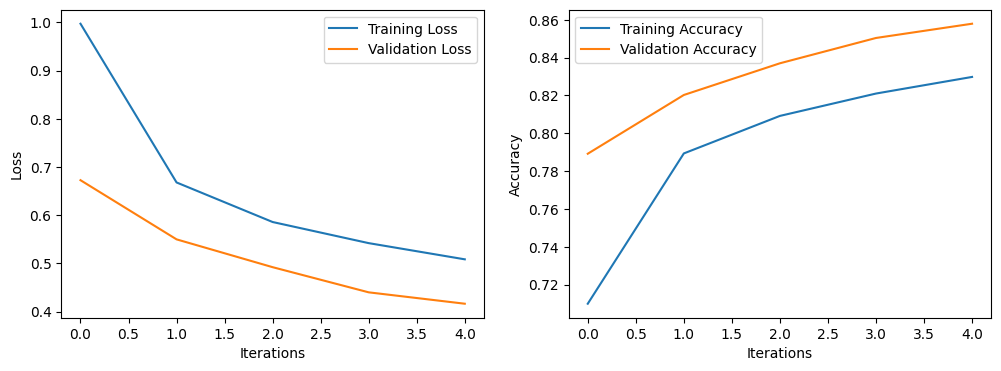

Test accuracy: 0.8365
Training time: 188.76 seconds
True Labels:  [14, 36, 37, 29, 32, 27]
Pred Labels:  [14, 36, 37, 29, 32, 39]


In [ ]:
# Define a function to build the MLP model with different hyperparameters and techniques
def build_mlp(input_size, output_size, hidden_size, activation_func, dropout, batch_norm, l1_reg, l2_reg):
  layers = [] # empty list to hold the four hidden layers
  prev_size = input_size
  for size in hidden_size:
    layers.append(nn.Linear(prev_size, size))
    if batch_norm:
      layers.append(nn.BatchNorm1d(size))
    layers.append(activation_func)
    if dropout:
      layers.append(nn.Dropout(dropout))
    prev_size = size
  layers.append(nn.Linear(prev_size, hidden_size[-1]))
  if batch_norm:
      layers.append(nn.BatchNorm1d(hidden_size[-1]))
  layers.append(activation_func)
  if dropout:
      layers.append(nn.Dropout(dropout))
  layers.append(nn.Linear(hidden_size[-1], hidden_size[-1]))
  if batch_norm:
      layers.append(nn.BatchNorm1d(hidden_size[-1]))
  layers.append(activation_func)
  if dropout:
      layers.append(nn.Dropout(dropout))
  layers.append(nn.Linear(hidden_size[-1], hidden_size[-1]))
  if batch_norm:
      layers.append(nn.BatchNorm1d(hidden_size[-1]))
  layers.append(activation_func)
  if dropout:
      layers.append(nn.Dropout(dropout))
  layers.append(nn.Linear(hidden_size[-1], output_size))
  return nn.Sequential(*layers)

def train_mlp(model, train_data, learning_rate, optimizer_func, 
              l1_weight, l2_weight, batch_size, num_epochs, device):
    # Define loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optimizer_func(model.parameters(), lr=learning_rate, weight_decay=l2_weight)

    # Define the K-fold cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    start_time = time.time()
    for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_data)):
       
        # Split data
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)
        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_subsampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_subsampler)

        # Initialize training variables
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        # Train the model
        model.train()
        for epoch in range(num_epochs):
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred = model(x.view(x.shape[0], -1)) #passing the feed forward
                loss = loss_fn(y_pred, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * x.shape[0]
                train_acc += (y_pred.argmax(1) == y).sum().item()
            train_loss /= len(train_loader.sampler)
            train_acc /= len(train_loader.sampler)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x.view(x.shape[0], -1))
                loss = loss_fn(y_pred, y)
                valid_loss += loss.item() * x.shape[0]
                valid_acc += (y_pred.argmax(1) == y).sum().item()
            valid_loss /= len(valid_loader.sampler)
            valid_acc /= len(valid_loader.sampler)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

    end_time = time.time()
    train_time = end_time - start_time
    return train_losses, train_accs, valid_losses, valid_accs, train_time

def train_best_model(train_data, test_data, hidden_size=[512], activation_func=nn.ReLU(),
                     dropout=0.2, batch_norm=True, l1_reg=0.0, l2_reg=0.0, learning_rate=0.001,
                     optimizer_func=torch.optim.Adam, batch_size=64, num_epochs=10, device=torch.device('cpu')):
  try:
    # Define model
    input_size = train_data[0][0].shape[0] * train_data[0][0].shape[1] * train_data[0][0].shape[2]
    output_size = len(train_data.classes)
    model = build_mlp(input_size, output_size, hidden_size, activation_func, dropout, batch_norm, l1_reg, l2_reg)
    model.to(device)

    # Train model with cross-validation
    train_losses, train_accs, valid_losses, valid_accs, train_time = train_mlp(model, train_data, learning_rate,
                                                                             optimizer_func, l1_reg, l2_reg, batch_size,
                                                                             num_epochs, device)

    # Plot loss and accuracy graphs for the training process
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(valid_accs, label='Validation Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Evaluate model on test set
    model.eval()
    with torch.no_grad():
        #test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
        true_labels = []
        pred_labels = []
        test_acc = 0.0
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x.view(x.shape[0], -1))
            true_labels.extend(y.tolist())
            pred_labels.extend(y_pred.argmax(1).tolist())
            test_acc += (y_pred.argmax(1) == y).sum().item()
        test_acc /= len(test_loader.sampler)
    print(f'Test accuracy: {test_acc:.4f}')
    print(f'Training time: {train_time:.2f} seconds')

    # Print the true and predicted labels for the top six samples in the testing dataset
    print("True Labels: ", true_labels[:6])
    print("Pred Labels: ", pred_labels[:6])
   
#print(train_dataset[0][0].shape) # Expected shape: (1, 28, 28)
#print(test_dataset[0][0].shape) # Expected shape: (1, 28, 28)

train_dataset1 = torch.utils.data.Subset(train_data, range(0, 1000))
test_dataset1 = torch.utils.data.Subset(test_data, range(0, 10))


mlp_params = train_best_model(train_dataset1.dataset, test_dataset1.dataset, hidden_size=[512], 
                 activation_func=nn.ReLU(), dropout=0.2, batch_norm=True, l1_reg=0.0, 
                 l2_reg=0.0, learning_rate=0.001, optimizer_func=torch.optim.Adam, 
                 batch_size=64, num_epochs=1, device=torch.device('cpu'));

**Step 5**
CNN

In [ ]:
# Define a function to build the CNN model with different hyperparameters and techniques
def build_cnn(input_shape, output_size, num_filters, filter_sizes, pooling_sizes,
              activation_func, dropout, batch_norm, l1_reg, l2_reg):
    if activation_func == 'relu':
       activation_func = nn.ReLU()
    elif activation_func == 'sigmoid':
       activation_func = nn.Sigmoid()
    elif activation_func == 'tanh':
       activation_func = nn.Tanh()
    elif activation_func == 'softmax':
       activation_func = nn.Softmax()
    elif activation_func == 'softplus':
       activation_func = nn.Softplus()
    elif activation_func == 'elu':
       activation_func = nn.ELU()
    else:
       raise ValueError('Unsupported activation function:', activation_func)
    layers = []
    prev_filters = input_shape[0]
    for i, (filters, filter_size, pooling_size) in enumerate(zip(num_filters, filter_sizes, pooling_sizes)):
        layers.append(nn.Conv2d(prev_filters, filters, filter_size))
        if batch_norm:
            layers.append(nn.BatchNorm2d(filters))
        layers.append(activation_func)
        layers.append(nn.MaxPool2d(pooling_size))
        if dropout:
            layers.append(nn.Dropout(dropout))
        prev_filters = filters
    layers.append(nn.Flatten())
    '''prev_filters * input_shape[1] // 2**(len(num_filters)*2)'''
    layers.append(nn.Linear(input_shape[1]*input_shape[2], output_size))
    return nn.Sequential(*layers)


def train_cnn(model, train_data, learning_rate, optimizer_func, 
              l1_weight, l2_weight, batch_size, num_epochs, device):
    # Define loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optimizer_func(model.parameters(), lr=learning_rate, weight_decay=l2_weight)

    # Define the K-fold cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    start_time = time.time()
    for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_data)):
        # Split data
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_ids)
        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_subsampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_subsampler)

        # Initialize training variables
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        # Train the model
        model.train()
        for epoch in range(num_epochs):
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * x.shape[0]
                train_acc += (y_pred.argmax(1) == y).sum().item()
            train_loss /= len(train_loader.sampler)
            train_acc /= len(train_loader.sampler)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                valid_loss += loss.item() * x.shape[0]
                valid_acc += (y_pred.argmax(1) == y).sum().item()
            valid_loss /= len(valid_loader.sampler)
            valid_acc /= len(valid_loader.sampler)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

    end_time = time.time()
    train_time = end_time - start_time
    return train_losses, train_accs, valid_losses, valid_accs, train_time


def train_best_model_cnn(train_data, test_data, input_shape=(1, 28, 28), output_size=10,
                         num_filters=[32, 64], filter_sizes=[5, 5], pooling_sizes=[2, 2], activation_func="relu",
                         dropout=0.0, batch_norm=False, l1_reg=0.0, l2_reg=0.0, learning_rate=0.001, optimizer_func=torch.optim.Adam,
                         l1_weight=0.0, l2_weight=0.0, batch_size=64, num_epochs=10, device=torch.device('cpu')):
  # Build the model
  model = build_cnn(input_shape, output_size, num_filters, 
                    filter_sizes, pooling_sizes, activation_func, 
                    dropout, batch_norm, l1_reg, l2_reg)
  # Train the model
  train_losses, train_accs, valid_losses, valid_accs, train_time = train_cnn(model, train_data, 
                                                                             learning_rate, optimizer_func, 
                                                                             l1_weight, l2_weight, batch_size, 
                                                                             num_epochs, device)

  # Evaluate on test set
  test_loader = DataLoader(test_data, batch_size=batch_size)
  model.eval()
  with torch.no_grad():
      test_loss = 0.0
      test_acc = 0.0
      true_labels = []
      pred_labels = []
      x_test = []
      for x, y in test_loader:
          x, y = x.to(device), y.to(device)
          y_pred = model(x)
          loss = nn.CrossEntropyLoss()(y_pred, y)
          test_loss += loss.item() * x.shape[0]
          test_acc += (y_pred.argmax(1) == y).sum().item()
          true_labels.extend(y.cpu().numpy())
          pred_labels.extend(y_pred.argmax(1).cpu().numpy())
          x_test.append(x.cpu().numpy())
      test_loss /= len(test_loader.dataset)
      test_acc /= len(test_loader.dataset)

  # Print results
  print(f"Train loss: {train_losses[-1]:.4f} | Train accuracy: {train_accs[-1]*100:.2f}%")
  print(f"Valid loss: {valid_losses[-1]:.4f} | Valid accuracy: {valid_accs[-1]*100:.2f}%")
  print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc*100:.2f}%")
  print(f"Train time: {train_time:.2f} seconds")


  return (model, true_labels, pred_labels, 
          train_losses, train_accs, valid_losses, valid_accs, test_loss, test_acc, train_time, x_test)


Checking for the best activation function

In [ ]:
train_dataset1 = torch.utils.data.Subset(train_data, range(0, 1000))
test_dataset1 = torch.utils.data.Subset(test_data, range(0, 10))
activations = ['sigmoid', 'relu']
cnn_params_array = []
for func in activations:
  print(f'activation function {func}')
  cnn_params = train_best_model_cnn(train_data = train_dataset1.dataset, test_data = test_dataset1.dataset, input_shape=(1, 28, 28), output_size=47,
                         num_filters=[32, 49], filter_sizes=[ 5, 5], pooling_sizes=[2, 2], activation_func=func,
                         dropout=0.0, batch_norm=False, l1_reg=0.0, l2_reg=0.0, learning_rate=0.001, optimizer_func=torch.optim.Adam,
                         l1_weight=0.0, l2_weight=0.0, batch_size=47, num_epochs=1, device=torch.device('cpu'))
  cnn_params_array.append(cnn_params)

activation function sigmoid
Train loss: 0.4076 | Train accuracy: 86.30%
Valid loss: 0.4062 | Valid accuracy: 86.47%
Test loss: 0.4604 | Test accuracy: 84.99%
Train time: 559.56 seconds
activation function relu
Train loss: 0.3102 | Train accuracy: 88.70%
Valid loss: 0.3010 | Valid accuracy: 88.94%
Test loss: 0.3711 | Test accuracy: 87.22%
Train time: 520.69 seconds


Batch Normalization with the best activation function

In [ ]:
batch = [False, True]
best_activation = 'relu'
cnn_params_array = []
for b in batch:
  print(f'Batch :{b}')
  cnn_params = train_best_model_cnn(train_data = train_dataset1.dataset, test_data = test_dataset1.dataset, input_shape=(1, 28, 28), output_size=47,
                         num_filters=[32, 49], filter_sizes=[ 5, 5], pooling_sizes=[2, 2], activation_func='relu',
                         dropout=0.0, batch_norm=b, l1_reg=0.0, l2_reg=0.0, learning_rate=0.001, optimizer_func=torch.optim.Adam,
                         l1_weight=0.0, l2_weight=0.0, batch_size=47, num_epochs=1, device=torch.device('cpu'))
  cnn_params_array.append(cnn_params)

Batch :False
Train loss: 0.3008 | Train accuracy: 89.03%
Valid loss: 0.3080 | Valid accuracy: 88.49%
Test loss: 0.3825 | Test accuracy: 86.64%
Train time: 528.65 seconds
Batch :True
Train loss: 0.3128 | Train accuracy: 88.67%
Valid loss: 0.3041 | Valid accuracy: 88.99%
Test loss: 0.3674 | Test accuracy: 87.50%
Train time: 596.21 seconds


A combination with the different learning rates

In [ ]:
learning_rate = [0.01, 0.1, 1]
best_bn = True
cnn_params_array = []
for l_r in learning_rate:
  print(f'Learning Rate : {l_r}')
  cnn_params = train_best_model_cnn(train_data = train_dataset1.dataset, test_data = test_dataset1.dataset, input_shape=(1, 28, 28), output_size=47,
                         num_filters=[32, 49], filter_sizes=[ 5, 5], pooling_sizes=[2, 2], activation_func='relu',
                         dropout=0.0, batch_norm=True, l1_reg=0.0, l2_reg=0.0, learning_rate=l_r, optimizer_func=torch.optim.Adam,
                         l1_weight=0.0, l2_weight=0.0, batch_size=47, num_epochs=1, device=torch.device('cpu'))
  cnn_params_array.append(cnn_params)

Learning Rate : 0.01
Train loss: 0.3278 | Train accuracy: 88.20%
Valid loss: 0.3076 | Valid accuracy: 88.91%
Test loss: 0.3764 | Test accuracy: 87.15%
Train time: 594.98 seconds
Learning Rate : 0.1
Train loss: 0.9063 | Train accuracy: 72.47%
Valid loss: 1.0342 | Valid accuracy: 70.02%
Test loss: 1.0444 | Test accuracy: 69.54%
Train time: 587.84 seconds
Learning Rate : 1
Train loss: 4.3109 | Train accuracy: 2.09%
Valid loss: 4.0282 | Valid accuracy: 2.26%
Test loss: 4.0302 | Test accuracy: 2.13%
Train time: 586.75 seconds


A combination with different dropout values

In [ ]:
Dropout_rate = [0.1, 0.5, 1]
best_learning_rate = 0.001
cnn_params_array = []
for d_r in Dropout_rate:
  print(f'Dropout Rate : {d_r}')
  cnn_params = train_best_model_cnn(train_data = train_dataset1.dataset, test_data = test_dataset1.dataset, input_shape=(1, 28, 28), output_size=47,
                         num_filters=[32, 49], filter_sizes=[ 5, 5], pooling_sizes=[2, 2], activation_func='relu',
                         dropout=d_r, batch_norm=True, l1_reg=0.0, l2_reg=0.0, learning_rate=0.001, optimizer_func=torch.optim.Adam,
                         l1_weight=0.0, l2_weight=0.0, batch_size=47, num_epochs=1, device=torch.device('cpu'))
  cnn_params_array.append(cnn_params)

Dropout Rate : 0.1
Train loss: 0.3391 | Train accuracy: 87.93%
Valid loss: 0.3021 | Valid accuracy: 89.34%
Test loss: 0.3489 | Test accuracy: 87.88%
Train time: 596.19 seconds
Dropout Rate : 0.5
Train loss: 0.4866 | Train accuracy: 83.61%
Valid loss: 0.3647 | Valid accuracy: 87.37%
Test loss: 0.3905 | Test accuracy: 86.65%
Train time: 571.42 seconds
Dropout Rate : 1
Train loss: 3.8505 | Train accuracy: 2.01%
Valid loss: 297.6638 | Valid accuracy: 1.99%
Test loss: 296.8509 | Test accuracy: 1.99%
Train time: 572.76 seconds


Combination with different epochs

In [ ]:
epochs = [2, 3]
best_dropout_rate = 0.1
cnn_params_array = []
for epoch in epochs:
  print(f'Epoch : {epoch}')
  cnn_params = train_best_model_cnn(train_data = train_dataset1.dataset, test_data = test_dataset1.dataset, input_shape=(1, 28, 28), output_size=47,
                         num_filters=[32, 49], filter_sizes=[ 5, 5], pooling_sizes=[2, 2], activation_func='relu',
                         dropout=d_r, batch_norm=True, l1_reg=0.0, l2_reg=0.0, learning_rate=0.001, optimizer_func=torch.optim.Adam,
                         l1_weight=0.0, l2_weight=0.0, batch_size=47, num_epochs= epoch, device=torch.device('cpu'))
  cnn_params_array.append(cnn_params)

Epoch : 2
Train loss: 3.8505 | Train accuracy: 2.00%
Valid loss: 301.6857 | Valid accuracy: 2.06%
Test loss: 300.9781 | Test accuracy: 2.13%
Train time: 1140.09 seconds
Epoch : 3
Train loss: 3.8505 | Train accuracy: 2.06%
Valid loss: 249.9863 | Valid accuracy: 2.89%
Test loss: 248.9464 | Test accuracy: 2.77%
Train time: 1600.96 seconds


Plotting CNN

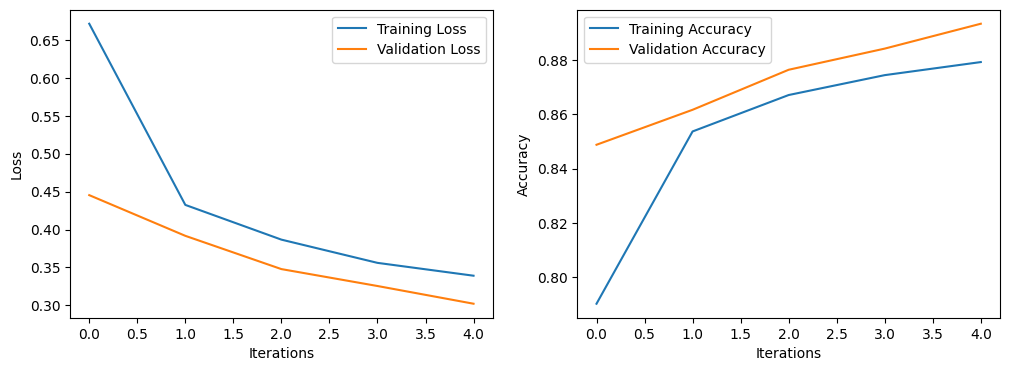

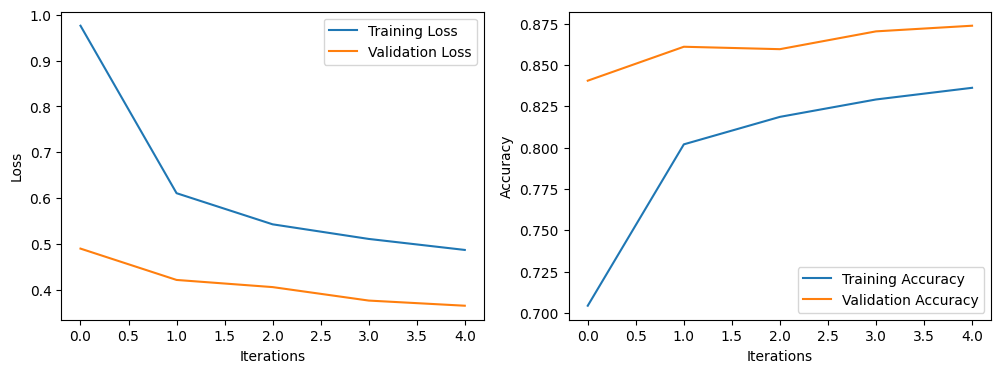

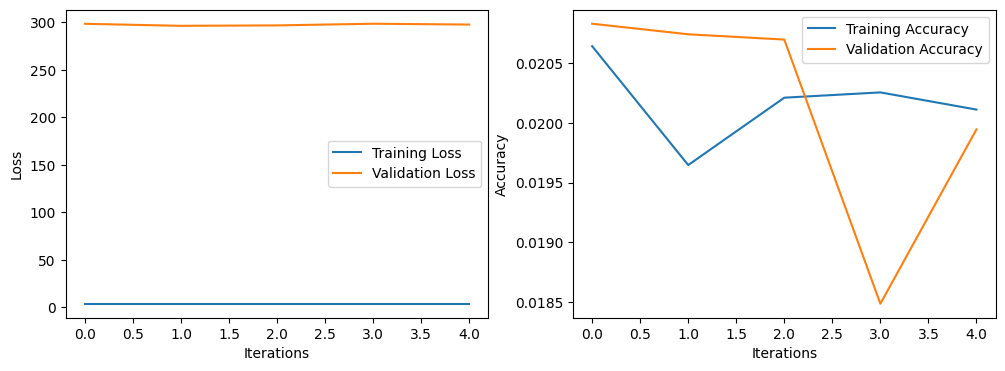

In [ ]:
def cnn_plot(train_losses, train_accs, valid_losses, valid_accs, test_loss, test_acc):
  # Plot loss and accuracy graphs for the training process
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Training Loss')
  plt.plot(valid_losses, label='Validation Loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accs, label='Training Accuracy')
  plt.plot(valid_accs, label='Validation Accuracy')
  plt.xlabel('Iterations')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
for cnn_params in cnn_params_array:
  print()
  cnn_plot(cnn_params[3], cnn_params[4], cnn_params[5], cnn_params[6], cnn_params[7], cnn_params[8])

Precision, Recall and F1_Score Functions for MLP and CNN

In [ ]:
def calculate_metrics(true_labels, pred_labels, num_classes):
    # Calculate precision, recall, and F1 score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, labels=list(range(num_classes)))
    
    # Calculate micro-averaged scores
    micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='micro')
    
    # Calculate macro-averaged scores
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro')
    
    # Print results
    #print("Precision per class: ", precision)
    #print("Recall per class: ", recall)
    #print("F1 score per class: ", f1)
    print("Micro-averaged precision: ", micro_precision)
    print("Micro-averaged recall: ", micro_recall)
    print("Micro-averaged F1 score: ", micro_f1)
    print("Macro-averaged precision: ", macro_precision)
    print("Macro-averaged recall: ", macro_recall)
    print("Macro-averaged F1 score: ", macro_f1)


MLP SUMMARY

In [ ]:
calculate_metrics(mlp_params[1], mlp_params[2], len(train_data.classes))

In [ ]:
print(mlp_params[0])

CNN SUMMARY

In [ ]:
for i in range(len(cnn_params_array)):
  print(f"")
  calculate_metrics(cnn_params_array[i][1], cnn_params_array[i][2], len(train_data.classes))
  


Micro-averaged precision:  0.8788297872340426
Micro-averaged recall:  0.8788297872340426
Micro-averaged F1 score:  0.8788297872340426
Macro-averaged precision:  0.8801103604766817
Macro-averaged recall:  0.8788297872340426
Macro-averaged F1 score:  0.8779314033769906

Micro-averaged precision:  0.8664893617021276
Micro-averaged recall:  0.8664893617021276
Micro-averaged F1 score:  0.8664893617021276
Macro-averaged precision:  0.8755208105492378
Macro-averaged recall:  0.8664893617021276
Macro-averaged F1 score:  0.8633408423854919

Micro-averaged precision:  0.0199468085106383
Micro-averaged recall:  0.0199468085106383
Micro-averaged F1 score:  0.0199468085106383
Macro-averaged precision:  0.012973085976144862
Macro-averaged recall:  0.019946808510638295
Macro-averaged F1 score:  0.0034502260027902323


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PLOTTING CONFUSION MATRIX FOR MLP

In [ ]:

def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels, labels=classes)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes, 
           title='Confusion Matrix', ylabel='True label', xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = '.2f' if cm.dtype == np.float32 else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", 
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax

# Compute the confusion matrix
y_test = [mapping[i] for i in mlp_params[0]]
y_pred = [mapping[i] for i in mlp_params[0])]
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, classes)


PLOTTING THE CONFUSSION MATRIX FOR CNN

In [ ]:

def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels, labels=classes)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes, 
           title='Confusion Matrix', ylabel='True label', xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = '.2f' if cm.dtype == np.float32 else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", 
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax

# Compute the confusion matrix
y_test = [mapping[i] for i in cnn_params_array[0][1]]
y_pred = [mapping[i] for i in cnn_params_array[0][2]]
cm = confusion_matrix(y_test, y_pred, labels=classes)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, classes)
